# Identifying Undervalued U23 Attackers: A Data-Driven Scouting Approach
#### Scoring models and clustering applied to Wyscout performance data (2020/21)
### By [Tomás Contreras](https://github.com/TomasContrerasD)
Notebook first written: 02/02/2026<br>
Notebook last updated: 09/02/2026

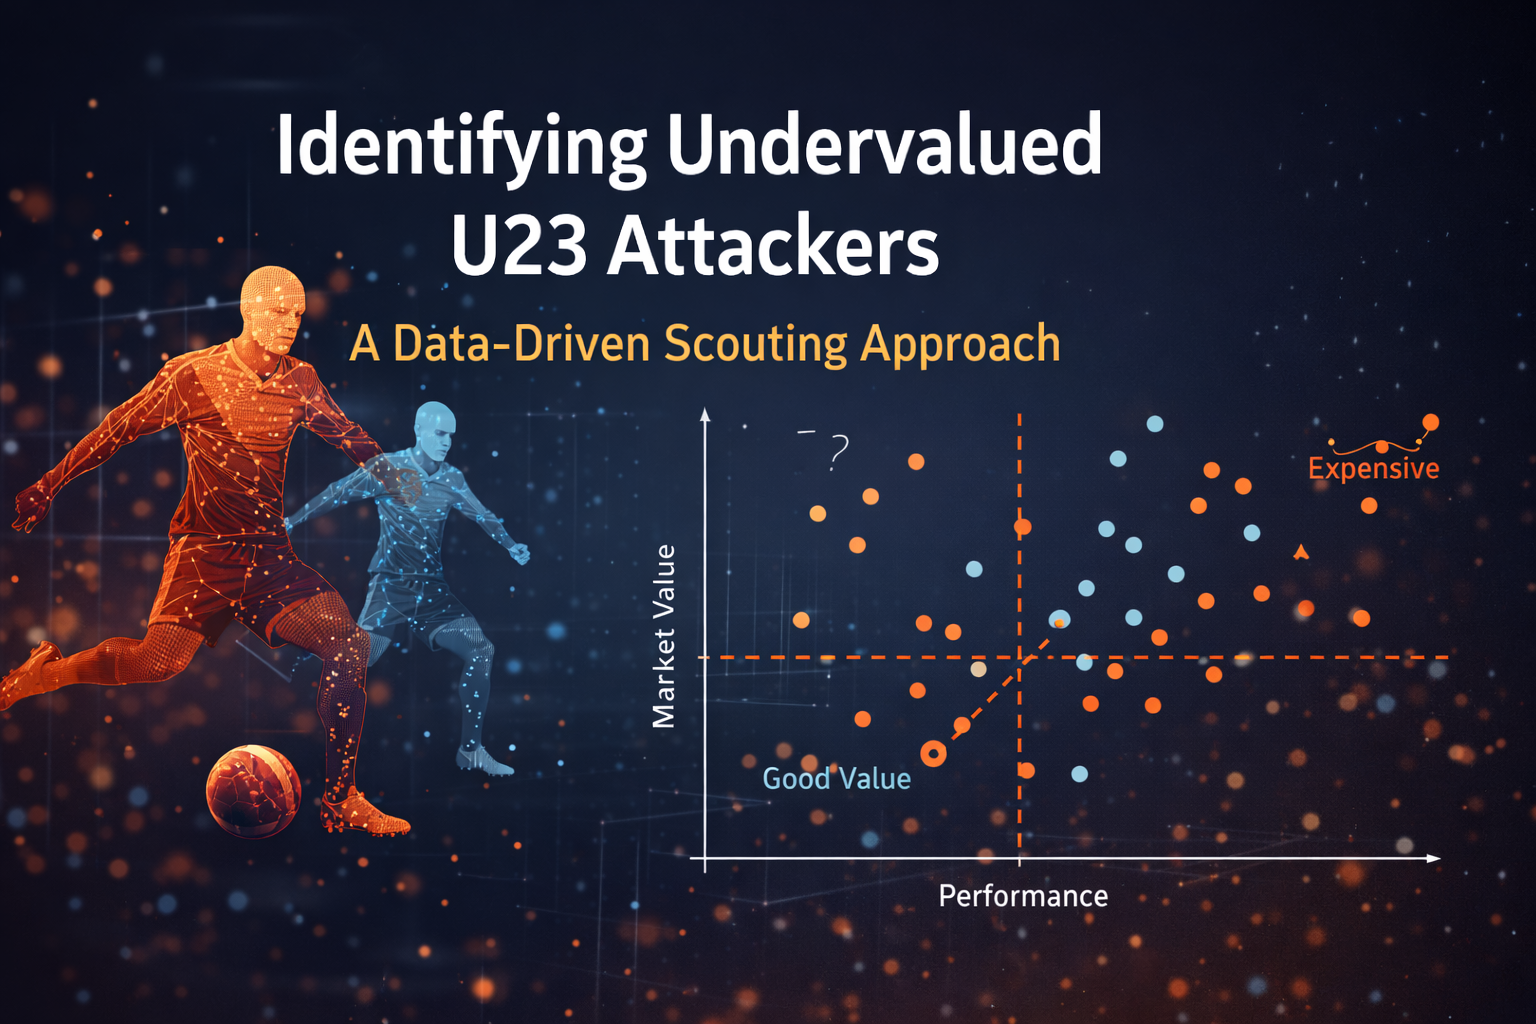

In [2]:
from IPython.display import Image, display
display(Image(filename="image u23 att.png", width=600))

---
## Project Overview
This project explores a data-driven scouting methodology aimed at identifying Sub-23 attacking players (forwards) who combine strong on-field performance with relatively low market value, using advanced event-based football metrics.

The analysis is based on data from the 2020/21 season, sourced from Wyscout, and focuses on transforming a high-dimensional performance dataset into actionable scouting insights through exploratory data analysis, feature engineering, scoring models, and unsupervised learning techniques.

The main goal of the project is not to predict outcomes or replicate a club’s proprietary recruitment model, but rather to explore and demonstrate a structured analytical approach to modern football scouting, particularly in contexts where traditional observation alone may overlook valuable profiles.

#### Exploratory Nature and Data Considerations

This work is exploratory in nature. The dataset reflects the realities of real-world football data:
* some variables contain measurement imprecision,
* contextual information is not always perfectly aligned across competitions,
* and certain positional or team assignments may be incomplete.

These limitations were addressed throughout the project via:
* careful filtering and segmentation (by position and minutes played),
* normalization and robustness checks,
* and an emphasis on relative comparisons rather than absolute judgments.

#### Pipeline

1) Exploratory Data Analysis (EDA),
2) a transparent performance–value scoring model,
3) and unsupervised clustering to identify player profiles and comparable alternatives.

The result is a reproducible and interpretable framework that illustrates how performance metrics can support scouting decisions, highlight market inefficiencies, and uncover players with similar profiles at lower cost.

---
# 1. Notebook Dependencies

This section defines the Python libraries and environment settings used throughout the notebook.
All dependencies are standard within the data science ecosystem and support data manipulation, visualization, feature scaling, and unsupervised learning.

## 1.1. Libraries

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

To improve readability during exploratory analysis, pandas display options are temporarily adjusted to allow full inspection of tables and variables.

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

After inspection, the default display settings are restored to avoid unnecessary verbosity

In [10]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')

---
# 2. Data Sources

The dataset used in this project is derived from event-level football data originally provided by Wyscout, and later engineered and aggregated by [Edd Webster](https://github.com/eddwebster/football_analytics/tree/master/data/wyscout) for analytical purposes.

These aggregated datasets are publicly available and are widely used within the football analytics community for educational and exploratory projects. They provide advanced performance metrics that would otherwise be difficult and costly to obtain directly from commercial providers.

More details about the data engineering process and structure can be found in the original repository.

In [12]:
# CSV engineered from Wyscout data by Edd Webster
url_wyscout_engineered = "https://raw.githubusercontent.com/eddwebster/football_analytics/refs/heads/master/data/wyscout/engineered/aggregated/wyscout_scotland_2bundesliga_belgium_1920_2021.csv"

df = pd.read_csv(url_wyscout_engineered)

Competitions included:
* Scottish Premiership
* 2nd Bundesliga
* Belgian First Division A

Seasons covered: 2019/20 and 2020/21

For this project, only data corresponding to the 2020/21 season is used.

---
# 3. Cleaning

The purpose of this section is to understand the structure of the dataset and apply the necessary filters

## 3.1 Initial Data Inspection

We start by inspecting the dataset to obtain a general overview of the variables and data types.

In [16]:
df.head()

,Player,Team,Position,Age,Market Value (EUR),Contract expires,Matches played,Minutes played,Goals,xG,...,Season,League,Primary Position,Secondary Position,Tertiary Position,Primary Position Grouped,Secondary Position Grouped,Tertiary Position Grouped,Outfielder Goalkeeper,Market Value (GBP)
0,O. Édouard,Celtic,CF,23,17000000,2022-05-31,31,2409,18,21.75,...,20/21,Scottish Premiership,CF,NaN,NaN,Forward,NaN,NaN,Outfielder,15300000.0
1,R. Kent,Rangers,"LWF, LAMF",24,14000000,2023-05-31,37,3128,10,7.75,...,20/21,Scottish Premiership,LWF,LAMF,NaN,Forward,Midfielder,NaN,Outfielder,12600000.0
2,M. Elyounoussi,Southampton,"LAMF, CF, AMF",27,12000000,2023-06-30,34,1868,10,10.53,...,20/21,Scottish Premiership,LAMF,CF,AMF,Midfielder,Forward,Midfielder,Outfielder,10800000.0
3,A. Morelos,Rangers,CF,25,12000000,2023-05-31,29,2143,12,13.68,...,20/21,Scottish Premiership,CF,NaN,NaN,Forward,NaN,NaN,Outfielder,10800000.0
4,J. Frimpong,Bayer Leverkusen,"RB, RWB",20,10000000,2025-06-30,22,1750,1,1.76,...,20/21,Scottish Premiership,RB,RWB,NaN,Defender,Defender,NaN,Outfielder,9000000.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2407 entries, 0 to 2406
Data columns (total 93 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player                               2407 non-null   object 
 1   Team                                 2270 non-null   object 
 2   Position                             2407 non-null   object 
 3   Age                                  2407 non-null   int64  
 4   Market Value (EUR)                   2407 non-null   int64  
 5   Contract expires                     2147 non-null   object 
 6   Matches played                       2407 non-null   int64  
 7   Minutes played                       2407 non-null   int64  
 8   Goals                                2407 non-null   int64  
 9   xG                                   2407 non-null   float64
 10  Assists                              2407 non-null   int64  
 11  xA                            

From this inspection, all variables appear to be correctly typed, allowing us to proceed with filtering based on the project scope.

## 3.2 Filtering by Age and Season

Since the project focuses exclusively on Sub-23 players from the 2020/21 season, all other observations are removed.

In [20]:
df_under23 = df[(df["Age"]<=23) & (df["Season"] == "20/21")]
df_under23.head()

,Player,Team,Position,Age,Market Value (EUR),Contract expires,Matches played,Minutes played,Goals,xG,...,Season,League,Primary Position,Secondary Position,Tertiary Position,Primary Position Grouped,Secondary Position Grouped,Tertiary Position Grouped,Outfielder Goalkeeper,Market Value (GBP)
0,O. Édouard,Celtic,CF,23,17000000,2022-05-31,31,2409,18,21.75,...,20/21,Scottish Premiership,CF,NaN,NaN,Forward,NaN,NaN,Outfielder,15300000.0
4,J. Frimpong,Bayer Leverkusen,"RB, RWB",20,10000000,2025-06-30,22,1750,1,1.76,...,20/21,Scottish Premiership,RB,RWB,NaN,Defender,Defender,NaN,Outfielder,9000000.0
9,K. Ajer,Brentford,"LCB, RB",23,7000000,2026-06-30,35,3187,2,2.15,...,20/21,Scottish Premiership,LCB,RB,NaN,Defender,Defender,NaN,Outfielder,6300000.0
11,I. Hagi,Rangers,"RWF, RCMF",22,6500000,2024-05-31,33,2031,7,5.38,...,20/21,Scottish Premiership,RWF,RCMF,NaN,Forward,Midfielder,NaN,Outfielder,5850000.0
19,D. Turnbull,Celtic,"AMF, LCMF, RCMF",22,5000000,2024-05-31,36,2575,9,7.43,...,20/21,Scottish Premiership,AMF,LCMF,RCMF,Midfielder,Midfielder,Midfielder,Outfielder,4500000.0


In [21]:
df_under23.shape

(476, 93)

This filtered dataset represents the analytical universe used throughout the remainder of the notebook.

## 3.3 Categorical Variables Cleaning

### Duplicate Detection

First, we check for fully duplicated rows.

In [26]:
df_under23[df_under23.duplicated(keep=False)]

,Player,Team,Position,Age,Market Value (EUR),Contract expires,Matches played,Minutes played,Goals,xG,...,Season,League,Primary Position,Secondary Position,Tertiary Position,Primary Position Grouped,Secondary Position Grouped,Tertiary Position Grouped,Outfielder Goalkeeper,Market Value (GBP)


Next, we check for players sharing the same name, which could indicate potential duplicates.

In [28]:
df_under23["Player"].value_counts().reset_index()[df_under23["Player"].value_counts().reset_index()["count"] > 1]

,Player,count
0,M. Johnston,2
1,J. Hamilton,2
2,R. McCrorie,2


In [29]:
df_under23[
    (df_under23["Player"] == "R. McCrorie") |
    (df_under23["Player"] == "J. Hamilton") |
    (df_under23["Player"] == "M. Johnston")
].sort_values("Player", ascending=False)

,Player,Team,Position,Age,Market Value (EUR),Contract expires,Matches played,Minutes played,Goals,xG,...,Season,League,Primary Position,Secondary Position,Tertiary Position,Primary Position Grouped,Secondary Position Grouped,Tertiary Position Grouped,Outfielder Goalkeeper,Market Value (GBP)
48,R. McCrorie,Aberdeen,"RCMF, LCMF, RCB",23,1000000,2024-05-31,29,2608,1,2.23,...,20/21,Scottish Premiership,RCMF,LCMF,RCB,Midfielder,Midfielder,Defender,Outfielder,900000.0
135,R. McCrorie,Rangers U20,GK,23,400000,2023-05-31,16,1515,0,0.00,...,20/21,Scottish Premiership,GK,NaN,NaN,Goalkeeper,NaN,NaN,Goalkeeper,360000.0
50,M. Johnston,Celtic,"CF, LAMF, AMF",22,1000000,2025-05-31,10,274,0,0.63,...,20/21,Scottish Premiership,CF,LAMF,AMF,Forward,Midfielder,Midfielder,Outfielder,900000.0
311,M. Johnston,Motherwell,"RB, RWB",17,0,NaN,2,118,0,0.00,...,20/21,Scottish Premiership,RB,RWB,NaN,Defender,Defender,NaN,Outfielder,0.0
113,J. Hamilton,Hamilton Academical,RCB,19,450000,2022-05-31,27,2025,0,0.49,...,20/21,Scottish Premiership,RCB,NaN,NaN,Defender,NaN,NaN,Outfielder,405000.0
243,J. Hamilton,Livingston,CF,21,250000,2022-05-31,5,183,1,0.53,...,20/21,Scottish Premiership,CF,NaN,NaN,Forward,NaN,NaN,Outfielder,225000.0


No duplicated players are found in the dataset.

### Missing Values in Categorical Variables

We then check for missing values

In [33]:
df_under23.isna().sum()

Player                          0
Team                           14
Position                        0
Age                             0
Market Value (EUR)              0
                             ... 
Primary Position Grouped        0
Secondary Position Grouped    181
Tertiary Position Grouped     340
Outfielder Goalkeeper           0
Market Value (GBP)              0
Length: 93, dtype: int64

To better understand the categorical variables, we inspect the distribution of values for each object-type column.

In [35]:
df_categorical = df_under23.select_dtypes(include="object")

for variable in df_categorical.columns:
    print(f"Values for variable: {variable}")
    print(df_categorical[variable].value_counts(dropna=False))
    print("-" * 40)


Values for variable: Player
Player
M. Johnston     2
J. Hamilton     2
R. McCrorie     2
O. Édouard      1
A. Musaba       1
               ..
E. Shuranov     1
N. Nartey       1
D. Borkowski    1
K. Sessa        1
E. Gueye        1
Name: count, Length: 473, dtype: int64
----------------------------------------
Values for variable: Team
Team
Anderlecht                 15
NaN                        14
Celtic                     11
Dundee United              11
KV Oostende                11
                           ..
Mainz 05                    1
CSKA Moskva                 1
Lens                        1
Hamilton Academical U19     1
Charleroi Res.              1
Name: count, Length: 157, dtype: int64
----------------------------------------
Values for variable: Position
Position
CF                47
RCB               20
GK                18
LCB               16
RCMF, LCMF        15
                  ..
RAMF, RW, RWB      1
LW, CF, LAMF       1
LWF, LAMF          1
AMF, RCMF, CF     

Key Observations:
1. Some players do not have a team assigned.
2. The variable Contract expires should be converted to a datetime format.

### Datetime Conversion

In [38]:
df_under23["Contract expires"] = pd.to_datetime(df_under23["Contract expires"], errors = "coerce")

### Players Without Team Assignment

In [40]:
df_under23[df_under23["Team"].isna()][["Player", "Team", "Minutes played"]]

,Player,Team,Minutes played
216,S. Seedorf,NaN,515
259,E. Ross,NaN,11
315,H. Robinson,NaN,16
944,B. Manu,NaN,108
980,M. Ćavar,NaN,5
1000,L. Hemmerich,NaN,160
1031,M. Kwarteng,NaN,41
1032,O. McKinze Gaines II,NaN,9
1047,N. Tarnat,NaN,7
1049,J. Hanek,NaN,5


Players without a team assignment still have recorded minutes played, indicating valid match participation.
Therefore, these observations are retained for the analysis.

## 3.4. Numerical Variables Cleaning

To simplify numerical analysis, we create a subset containing only numeric variables

In [44]:
cols_num = ["Player"] + df_under23.select_dtypes(exclude="object").columns.tolist()

df_num = df_under23[cols_num]

In [45]:
# We then inspect summary statistics
df_num.describe()

,Age,Market Value (EUR),Contract expires,Matches played,Minutes played,Goals,xG,Assists,xA,Height,...,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",Market Value (GBP)
count,476.000000,4.760000e+02,426,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,...,401.000000,401.000000,401.000000,384.000000,384.000000,384.000000,401.000000,476.000000,476.000000,4.760000e+02
mean,21.058824,1.360977e+06,2023-07-21 18:38:52.394366464,13.808824,895.607143,1.151261,1.234076,0.707983,0.697584,165.783613,...,0.373616,5.479277,69.283691,0.134505,0.028880,2.984557,0.250075,0.092437,2.692895,1.224879e+06
min,16.000000,0.000000e+00,2021-11-30 00:00:00,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,20.000000,2.000000e+05,2022-06-30 00:00:00,3.000000,97.750000,0.000000,0.000000,0.000000,0.000000,175.000000,...,0.000000,3.100000,62.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.800000e+05
50%,21.000000,4.000000e+05,2023-06-30 00:00:00,10.000000,511.500000,0.000000,0.415000,0.000000,0.190000,181.000000,...,0.200000,5.400000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.600000e+05
75%,22.000000,1.200000e+06,2024-06-30 00:00:00,24.000000,1537.500000,1.000000,1.450000,1.000000,0.780000,186.000000,...,0.570000,7.580000,78.380000,0.050000,0.000000,0.000000,0.070000,0.000000,0.000000,1.080000e+06
max,23.000000,2.600000e+07,2026-06-30 00:00:00,38.000000,3540.000000,18.000000,21.750000,10.000000,10.130000,198.000000,...,2.120000,15.250000,100.000000,3.050000,0.930000,100.000000,5.730000,11.000000,100.000000,2.340000e+07
std,1.648191,2.752091e+06,NaN,11.418877,950.455646,2.464531,2.371914,1.420459,1.245622,52.036156,...,0.463321,3.056665,17.338680,0.372864,0.103192,13.174389,0.673155,0.716619,15.703252,2.476882e+06


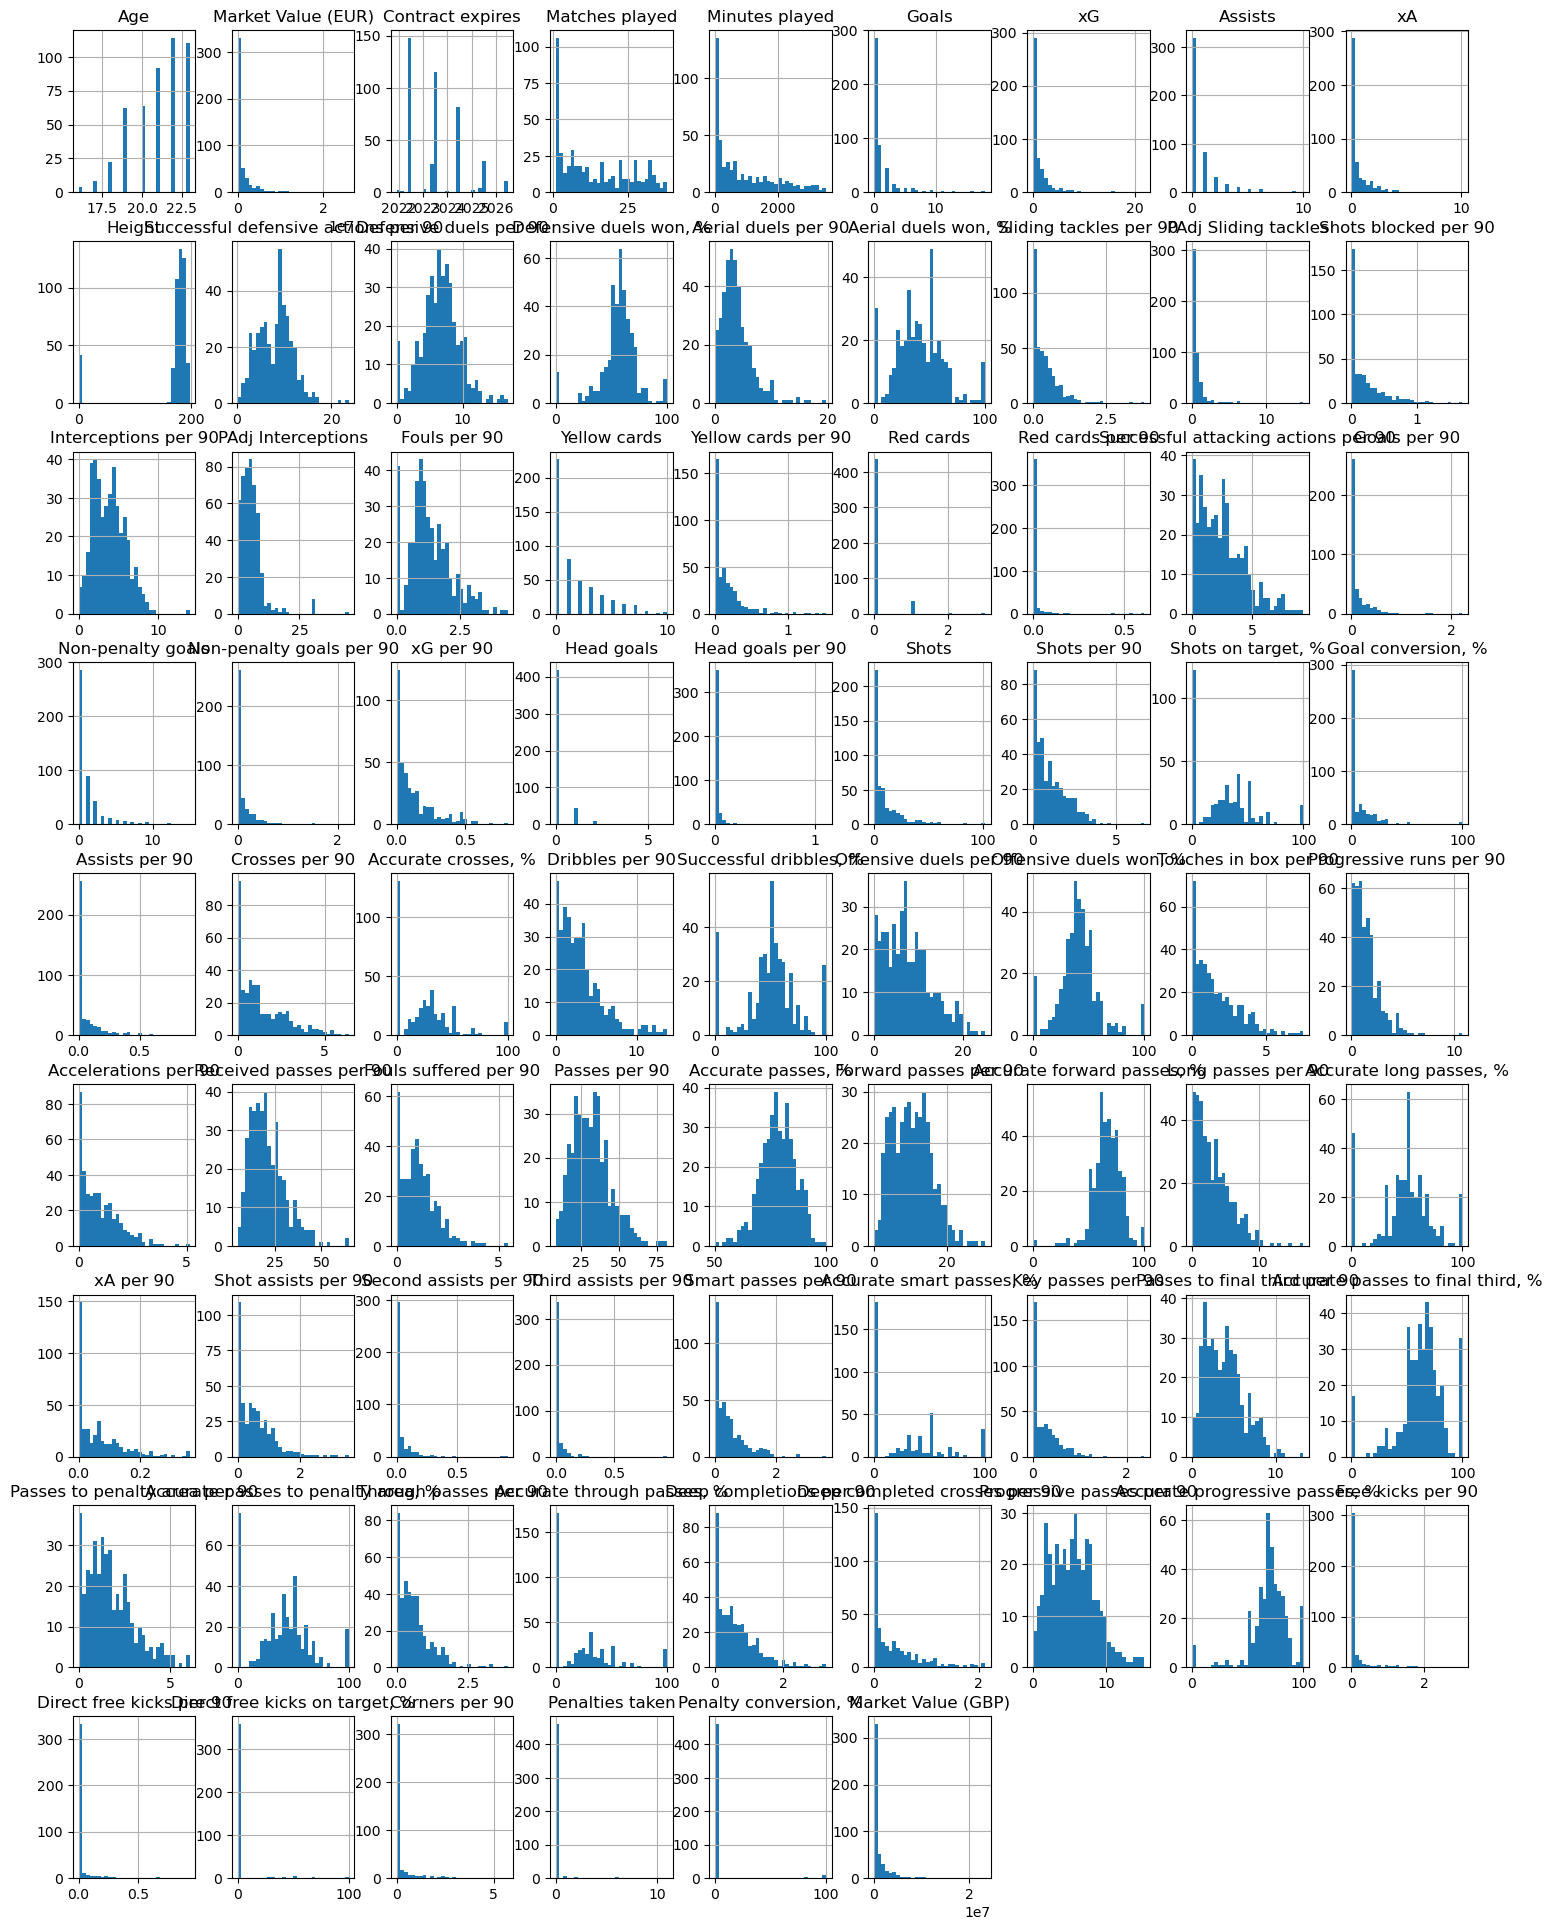

In [46]:
# And visualize the distributions.
df_num.hist(
    figsize=(18, 24),
    bins=30
);

Key Observations:
1. Market value contains players with a value of 0.
   - These players are retained, as market values can be updated externally (e.g., Transfermarkt) if a player appears attractive from a performance perspective.


3. Height includes at least one value equal to 0 cm.
   - While clearly incorrect, this does not materially affect the analysis and does not justify discarding the player.


5. Other numerical variables fall within plausible football-related ranges.
   - Although some visual outliers exist, they represent realistic in-game events rather than data errors.

### Targeted Checks

In [49]:
# Market Value
df_under23[df_under23["Market Value (EUR)"] < 10]

,Player,Team,Position,Age,Market Value (EUR),Contract expires,Matches played,Minutes played,Goals,xG,...,Season,League,Primary Position,Secondary Position,Tertiary Position,Primary Position Grouped,Secondary Position Grouped,Tertiary Position Grouped,Outfielder Goalkeeper,Market Value (GBP)
310,A. Montgomery,Celtic,LB,19,0,NaT,2,75,0,0.00,...,20/21,Scottish Premiership,LB,NaN,NaN,Defender,NaN,NaN,Outfielder,0.0
311,M. Johnston,Motherwell,"RB, RWB",17,0,NaT,2,118,0,0.00,...,20/21,Scottish Premiership,RB,RWB,NaN,Defender,Defender,NaN,Outfielder,0.0
312,L. King,Rangers U18,RB,17,0,2022-05-31,1,6,0,0.00,...,20/21,Scottish Premiership,RB,NaN,NaN,Defender,NaN,NaN,Outfielder,0.0
313,R. Edmondson,Fleetwood Town,CF,20,0,2023-06-30,14,408,2,1.09,...,20/21,Scottish Premiership,CF,NaN,NaN,Forward,NaN,NaN,Outfielder,0.0
314,T. Magloire,Blackburn Rovers U23,RCB,22,0,2022-06-30,10,831,0,0.15,...,20/21,Scottish Premiership,RCB,NaN,NaN,Defender,NaN,NaN,Outfielder,0.0
315,H. Robinson,NaN,RW,20,0,NaT,1,16,0,0.00,...,20/21,Scottish Premiership,RW,NaN,NaN,Forward,NaN,NaN,Outfielder,0.0
316,A. Okoflex,West Ham United U23,CF,19,0,2023-06-30,2,47,0,0.00,...,20/21,Scottish Premiership,CF,NaN,NaN,Forward,NaN,NaN,Outfielder,0.0
317,R. Duncan,Aberdeen U20,RW,17,0,NaT,1,10,0,0.00,...,20/21,Scottish Premiership,RW,NaN,NaN,Forward,NaN,NaN,Outfielder,0.0
318,D. Reid,St. Mirren,LCMF,16,0,2023-05-31,1,4,0,0.00,...,20/21,Scottish Premiership,LCMF,NaN,NaN,Midfielder,NaN,NaN,Outfielder,0.0
320,M. Redfern,Hamilton Academical,AMF,18,0,2023-05-31,1,27,0,0.00,...,20/21,Scottish Premiership,AMF,NaN,NaN,Midfielder,NaN,NaN,Outfielder,0.0


In [50]:
# Height
df_under23[df_under23["Height"] < 100]

,Player,Team,Position,Age,Market Value (EUR),Contract expires,Matches played,Minutes played,Goals,xG,...,Season,League,Primary Position,Secondary Position,Tertiary Position,Primary Position Grouped,Secondary Position Grouped,Tertiary Position Grouped,Outfielder Goalkeeper,Market Value (GBP)
20,J. Doig,Hibernian,"LB, LWB",19,4000000,2025-05-31,28,2086,1,0.88,...,20/21,Scottish Premiership,LB,LWB,NaN,Defender,Defender,NaN,Outfielder,3600000.0
201,L. Hjelde,Celtic Reserve,"LB, LWB, LCB",17,300000,2022-05-31,11,995,1,0.22,...,20/21,Scottish Premiership,LB,LWB,LCB,Defender,Defender,Defender,Outfielder,270000.0
244,B. Stirling,Hamilton Academical,"RCB, LCMF",22,250000,2022-05-31,20,1413,0,0.09,...,20/21,Scottish Premiership,RCB,LCMF,NaN,Defender,Midfielder,NaN,Outfielder,225000.0
261,C. Ramsay,Aberdeen U20,RB,18,200000,2024-05-31,4,105,0,0.00,...,20/21,Scottish Premiership,RB,NaN,NaN,Defender,NaN,NaN,Outfielder,180000.0
263,J. Henderson,St. Mirren,"LWB, RWB, RW",19,200000,2023-05-31,5,363,0,0.77,...,20/21,Scottish Premiership,LWB,RWB,RW,Defender,Defender,Forward,Outfielder,180000.0
271,J. MacKenzie,Aberdeen,LB,21,175000,2023-05-31,6,498,0,0.00,...,20/21,Scottish Premiership,LB,NaN,NaN,Defender,NaN,NaN,Outfielder,157500.0
280,K. Smith,Dundee United,RCB,16,100000,2023-05-31,5,308,0,0.00,...,20/21,Scottish Premiership,RCB,NaN,NaN,Defender,NaN,NaN,Outfielder,90000.0
281,S. Bradley,Hibernian,RW,19,100000,2022-05-31,2,25,0,0.07,...,20/21,Scottish Premiership,RW,NaN,NaN,Forward,NaN,NaN,Outfielder,90000.0
282,A. Meekison,Dundee United,"RCMF, LCMF",19,100000,2022-05-31,3,160,1,0.22,...,20/21,Scottish Premiership,RCMF,LCMF,NaN,Midfielder,Midfielder,NaN,Outfielder,90000.0
287,T. Brindley,Kilmarnock,LDMF,19,100000,2022-05-31,1,15,0,0.00,...,20/21,Scottish Premiership,LDMF,NaN,NaN,Midfielder,NaN,NaN,Outfielder,90000.0


Given the exploratory nature of the project and the limited impact of these anomalies, no rows are removed at this stage.

## Summary of the Cleaning Step

After filtering and inspection:
* the dataset contains no duplicated players,
* categorical inconsistencies are minimal and manageable,
* numerical anomalies are rare and non-critical,
* and all remaining observations are suitable for exploratory analysis.

This cleaned dataset provides a reliable foundation for the Exploratory Data Analysis (EDA) stage

---
# 4. Exploratory Data Analysis (EDA)

The purpose of this EDA is to understand the structure, quality, and relationships within the data before moving into modeling, ensuring that the subsequent analysis is based on meaningful signal rather than noise.

The EDA is structured as follows:
1. Segmentation by position
2. Minutes played distribution (to avoid modeling noise)
3. Correlation and distribution analysis
4. Performance vs. market value relationship
6. Detection of “good” outliers (high performance, low price)

Each step progressively narrows the analytical focus toward a scouting-oriented perspective.

## 4.1. Segmentation by Position

In principle, differences in league competitiveness can strongly affect player performance metrics.
Likewise, comparing players across different positions is rarely meaningful.

Therefore, an initial attempt is made to segment players by league and position.

### League Sanity Check

In [59]:
# We first inspect the number of teams per league.
df_under23.groupby("League")["Team"].nunique()

League
2. Bundesliga               49
Belgian First Division A    65
Scottish Premiership        49
Name: Team, dtype: int64

In [60]:
# We then examine the unique league–team combinations.
df_under23[["League", "Team"]].drop_duplicates().sort_values(["League", "Team"])


,League,Team
607,2. Bundesliga,Arminia Bielefeld
603,2. Bundesliga,Bochum
795,2. Bundesliga,Bolton Wanderers
625,2. Bundesliga,CSKA Moskva
1037,2. Bundesliga,Carl Zeiss Jena
...,...,...
245,Scottish Premiership,Tranmere Rovers
316,Scottish Premiership,West Ham United U23
286,Scottish Premiership,Wigan Athletic
308,Scottish Premiership,ÍA


This inspection reveals inconsistencies in the league–team assignments, indicating that league labels are not fully reliable in this dataset.

Given that:
* league assignment errors are outside the scope of this project,
* and the core objective is methodological scouting exploration rather than league comparison,

the league variable is excluded from further analysis, while all teams are retained

### Position Processing

Since players may appear with multiple listed positions, only the primary position (first listed) is retained to simplify role assignment.

In [64]:
df_under23["position_primary"] = (df_under23["Position"].astype(str).str.split(",").str[0].str.strip())

In [65]:
macro_map = {
    # GK
    "GK": "GK",

    # DEF
    "CB": "DEF", "LCB": "DEF", "RCB": "DEF",
    "LB": "DEF", "RB": "DEF", "LWB": "DEF", "RWB": "DEF",

    # MID
    "DMF": "MID", "LDMF": "MID", "RDMF": "MID",
    "CMF": "MID", "LCMF": "MID", "RCMF": "MID",
    "AMF": "MID", "LAMF": "MID", "RAMF": "MID",

    # ATT
    "CF": "ATT", "ST": "ATT",
    "LW": "ATT", "RW": "ATT",
    "LWF": "ATT", "RWF": "ATT",
}


In [66]:
df_under23["macro_position"] = df_under23["position_primary"].map(macro_map)


In [67]:
# We then inspect the resulting distribution
df_under23["macro_position"].value_counts(dropna=False)

macro_position
MID    170
DEF    147
ATT    141
GK      18
Name: count, dtype: int64

### Market Value Filtering

To avoid distortions in later economic analysis, players with missing or zero market value are removed at this stage.

In [70]:
df_under23 = df_under23[df_under23["Market Value (EUR)"] > 0]

This ensures that all remaining observations can be meaningfully evaluated in performance–value comparisons.

## 4.2. Minutes Played Distribution

Before comparing player performance, it is essential to understand exposure. <br>
Players with very limited minutes are more likely to display statistical noise rather than stable performance patterns.

We start by visualizing the distribution of minutes played.

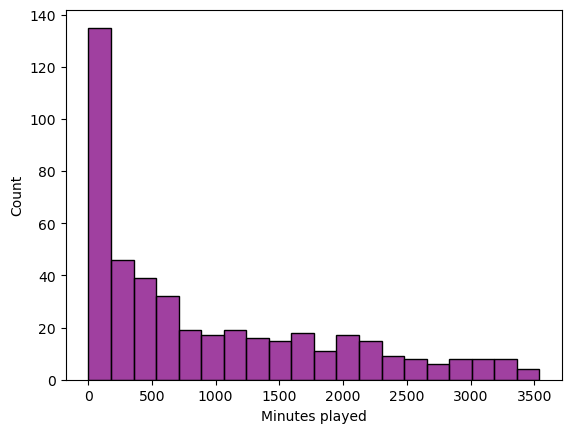

In [74]:
sns.histplot(df_under23["Minutes played"], bins = 20, color = "purple");

The distribution is strongly right-skewed, indicating that many players have limited minutes, while a smaller group accumulates substantial playing time.

### Outlier Analysis (IQR Method)

To better understand the dispersion, we compute quartiles and interquartile range (IQR).

In [78]:
s = df_under23["Minutes played"]

q1 = s.quantile(0.25)
q2 = s.quantile(0.50)
q3 = s.quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

out_low  = df_under23[s < lower]
out_high = df_under23[s > upper]

print(f"Q1={q1:.0f}, Median={q2:.0f}, Q3={q3:.0f}, IQR={iqr:.0f}")
print(f"Lower fence={lower:.0f}, Upper fence={upper:.0f}")
print(f"Outliers low={len(out_low)}, Outliers high={len(out_high)}")


Q1=110, Median=588, Q3=1588, IQR=1478
Lower fence=-2106, Upper fence=3804
Outliers low=0, Outliers high=0


A professional football season typically consists of:
* ~30 matches,
* with an average of ~58 minutes played per appearance,

which yields approximately 1,700–1,800 minutes per season for a regularly used player.

Based on this:
1. players with >1500 minutes can be considered regular contributors,
2. players with 300–1500 minutes are often rotational or developing players,
3. players with <300 minutes have very limited exposure,
4. players with ≤15 minutes provide insufficient information and are excluded.

### Minutes-Based Filtering and Bucketing

In [81]:
df_under23_clean = df_under23[df_under23["Minutes played"]>15]

In [82]:
bins = [-1, 300, 1500, s.max()]
labels = ["<300", "300-1500", "1500+"]

df_under23_clean["minutes_bucket"] = pd.cut(s, bins=bins, labels=labels)
df_under23_clean["minutes_bucket"].value_counts(dropna=False)


minutes_bucket
300-1500    159
<300        134
1500+       122
Name: count, dtype: int64

The resulting buckets are reasonably balanced, allowing meaningful comparisons within each exposure group.

### Distribution by Bucket

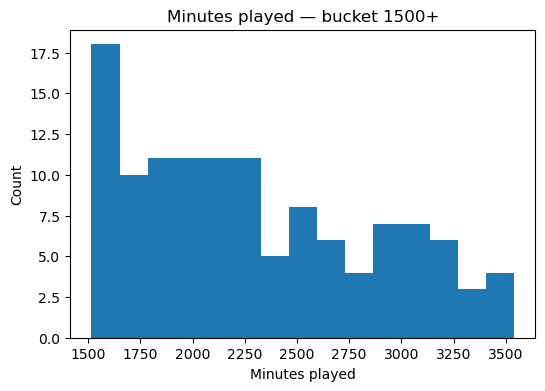

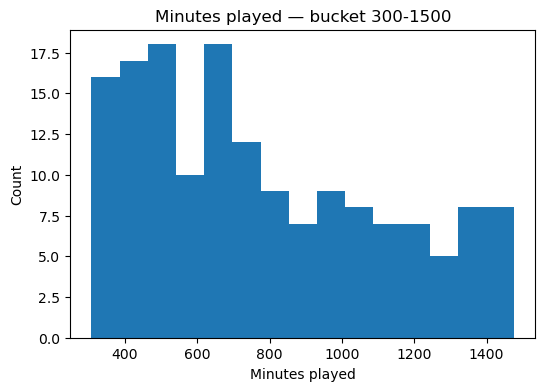

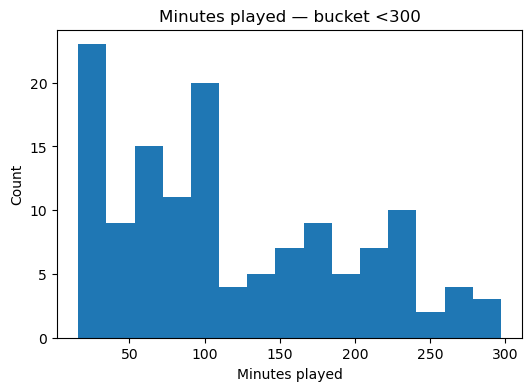

In [85]:
buckets = df_under23_clean["minutes_bucket"].dropna().unique()

for bucket in buckets:
    data = df_under23_clean.loc[
        df_under23_clean["minutes_bucket"] == bucket,
        "Minutes played"
    ]

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=15)
    plt.title(f"Minutes played — bucket {bucket}")
    plt.xlabel("Minutes played")
    plt.ylabel("Count")
    plt.show()

This segmentation ensures that players are compared only against others with similar opportunity levels

## 4.3. Correlation and distribution analysis

The goal of this section is to:
1. identify metrics that provide complementary information,
2. detect redundant features,
3. and assess statistical quality before modeling.

Low or moderate correlations are preferred, as they indicate that variables are capturing different dimensions of performance.

### Dataset Segmentation by Minutes and Position

In [89]:
df_1500 = df_under23_clean[df_under23_clean["minutes_bucket"] == "1500+"]
df_300_1500 = df_under23_clean[df_under23_clean["minutes_bucket"] == "300-1500"]
df_300 = df_under23_clean[df_under23_clean["minutes_bucket"] == "<300"]

In [90]:
# I created more df in case of future analysis
df_1500_ATT = df_1500[df_1500["macro_position"] == "ATT"]
df_1500_MID = df_1500[df_1500["macro_position"] == "MID"]
df_1500_DEF = df_1500[df_1500["macro_position"] == "DEF"]
df_1500_GK  = df_1500[df_1500["macro_position"] == "GK"]

df_300_1500_ATT = df_300_1500[df_300_1500["macro_position"] == "ATT"]
df_300_1500_MID = df_300_1500[df_300_1500["macro_position"] == "MID"]
df_300_1500_DEF = df_300_1500[df_300_1500["macro_position"] == "DEF"]
df_300_1500_GK  = df_300_1500[df_300_1500["macro_position"] == "GK"]

df_300_ATT = df_300[df_300["macro_position"] == "ATT"]
df_300_MID = df_300[df_300["macro_position"] == "MID"]
df_300_DEF = df_300[df_300["macro_position"] == "DEF"]
df_300_GK  = df_300[df_300["macro_position"] == "GK"]


In [91]:
dfs = {
    "df_1500_ATT": df_1500_ATT,
    "df_1500_MID": df_1500_MID,
    "df_1500_DEF": df_1500_DEF,
    "df_1500_GK": df_1500_GK,
    "df_300_1500_ATT": df_300_1500_ATT,
    "df_300_1500_MID": df_300_1500_MID,
    "df_300_1500_DEF": df_300_1500_DEF,
    "df_300_1500_GK": df_300_1500_GK,
    "df_300_ATT": df_300_ATT,
    "df_300_MID": df_300_MID,
    "df_300_DEF": df_300_DEF,
    "df_300_GK": df_300_GK,
}

for name, df_ in dfs.items():
    print(f"{name}: {df_.shape}")

df_1500_ATT: (27, 96)
df_1500_MID: (45, 96)
df_1500_DEF: (44, 96)
df_1500_GK: (6, 96)
df_300_1500_ATT: (52, 96)
df_300_1500_MID: (47, 96)
df_300_1500_DEF: (55, 96)
df_300_1500_GK: (5, 96)
df_300_ATT: (47, 96)
df_300_MID: (47, 96)
df_300_DEF: (35, 96)
df_300_GK: (5, 96)


Given the project scope, the remainder of the analysis focuses on ATT players with more than 1500 minutes.

### 4.3.1. Feature Diagnostics — ATT | Minutes > 1500

The objective is to assess feature quality through:
1. zero inflation,
2. skewness,
3. near-zero variance,
4. scale compatibility,
5. correlation structure.

### Feature Selection

In [96]:
ATT_columns = ['Market Value (EUR)',
       'Matches played', 'Minutes played', 'xG','xA', 
       'Successful defensive actions per 90', 'Defensive duels per 90',
       'Defensive duels won, %', 'Aerial duels per 90', 'Aerial duels won, %',
       'Sliding tackles per 90', 'PAdj Sliding tackles',
       'Shots blocked per 90', 'Interceptions per 90', 'PAdj Interceptions',
       'Fouls per 90', 'Successful attacking actions per 90',
       'Goals per 90', 'Non-penalty goals', 'Non-penalty goals per 90',
       'xG per 90', 'Head goals per 90', 'Shots per 90',
       'Shots on target, %', 'Goal conversion, %', 'Assists per 90',
       'Crosses per 90', 'Accurate crosses, %', 'Dribbles per 90',
       'Successful dribbles, %', 'Offensive duels per 90',
       'Offensive duels won, %', 'Touches in box per 90',
       'Progressive runs per 90', 'Accelerations per 90',
       'Received passes per 90', 'Fouls suffered per 90', 'Passes per 90',
       'Accurate passes, %', 'Forward passes per 90',
       'Accurate forward passes, %', 'Long passes per 90',
       'Accurate long passes, %', 'xA per 90', 'Shot assists per 90',
       'Second assists per 90', 'Third assists per 90', 'Smart passes per 90',
       'Accurate smart passes, %', 'Key passes per 90',
       'Passes to final third per 90', 'Accurate passes to final third, %',
       'Passes to penalty area per 90', 'Accurate passes to penalty area, %',
       'Through passes per 90', 'Accurate through passes, %',
       'Deep completions per 90', 'Deep completed crosses per 90',
       'Progressive passes per 90', 'Accurate progressive passes, %',
       'Free kicks per 90', 'Direct free kicks per 90',
       'Direct free kicks on target, %', 'Corners per 90', 'Penalties taken',
       'Penalty conversion, %', 'Market Value (GBP)']

### Variables with High Zero Ratio

In [98]:
zero_ratio = (df_1500_ATT[ATT_columns] == 0).mean().sort_values(ascending=False)

zero_ratio_df = zero_ratio.reset_index()
zero_ratio_df.columns = ["variable", "zero_ratio"]

zero_ratio_df[zero_ratio_df["zero_ratio"] > 0.5]



,variable,zero_ratio
0,"Direct free kicks on target, %",0.740741
1,Direct free kicks per 90,0.703704
2,"Penalty conversion, %",0.666667
3,Penalties taken,0.666667
4,Head goals per 90,0.629630
5,Third assists per 90,0.592593
6,Free kicks per 90,0.518519


Variables with >50% zeros:
* Direct free kicks on target, %
* Direct free kicks per 90
* Penalty conversion, %
* Penalties taken
* Head goals per 90
* Third assists per 90
* Free kicks per 90

### Skewness Analysis

In [101]:
skewness = df_1500_ATT[ATT_columns].skew().sort_values(key=np.abs, ascending=False)

skewness_df = skewness.reset_index()
skewness_df.columns = ["variable", "skewness"]

skewness_df[np.abs(skewness_df["skewness"]) > 2]

,variable,skewness
0,Penalties taken,3.026983
1,Direct free kicks per 90,2.966014
2,Free kicks per 90,2.698889
3,Corners per 90,2.496531
4,Head goals per 90,2.371133


Strongly skewed variables include:
* Penalties taken
* Direct free kicks per 90
* Free kicks per 90
* Corners per 90
* Head goals per 90

### Near-Zero Variance

In [104]:
variance = df_1500_ATT[ATT_columns].var().sort_values()

variance_df = variance.reset_index()
variance_df.columns = ["variable", "variance"]

variance_df[variance_df["variance"] < 0.01]

,variable,variance
0,Third assists per 90,0.001103
1,Head goals per 90,0.002876
2,Second assists per 90,0.004098
3,xA per 90,0.004727
4,Assists per 90,0.008154
5,Shots blocked per 90,0.008901


Variables with very low variance:
* Third assists per 90
* Head goals per 90
* Second assists per 90
* xA per 90
* Assists per 90
* Shots blocked per 90

### Scale Compatibility

In [107]:
scale_summary = pd.DataFrame({
    "mean": df_1500_ATT[ATT_columns].mean(),
    "std": df_1500_ATT[ATT_columns].std(),
    "min": df_1500_ATT[ATT_columns].min(),
    "max": df_1500_ATT[ATT_columns].max()
})

scale_summary.assign(
    range=lambda x: x["max"] - x["min"]
).sort_values("range", ascending=False)


,mean,std,min,max,range
Market Value (EUR),5.061111e+06,6.196406e+06,400000.00,22000000.00,21600000.00
Market Value (GBP),4.555000e+06,5.576766e+06,360000.00,19800000.00,19440000.00
Minutes played,2.138185e+03,4.446481e+02,1524.00,3317.00,1793.00
"Penalty conversion, %",3.204263e+01,4.637508e+01,0.00,100.00,100.00
"Accurate through passes, %",3.261815e+01,1.222402e+01,0.00,60.00,60.00
...,...,...,...,...,...
Shots blocked per 90,8.629630e-02,9.434585e-02,0.00,0.32,0.32
xA per 90,1.296296e-01,6.875159e-02,0.02,0.30,0.28
Second assists per 90,5.851852e-02,6.401344e-02,0.00,0.24,0.24
Head goals per 90,3.074074e-02,5.363164e-02,0.00,0.23,0.23


No extreme scale incompatibilities are observed among game-related metrics

### Correlation Analysis

To simplify interpretation, we focus on percentage-based metrics and previously retained variables

In [111]:
ATT_columns2 = ['xG','xA', 
       'Defensive duels won, %', 'Aerial duels won, %',
       'Shots on target, %', 'Goal conversion, %', 'Accurate crosses, %',
       'Successful dribbles, %', 
       'Offensive duels won, %', 
       'Accurate passes, %', 
       'Accurate forward passes, %',
       'Accurate long passes, %', 
       'Accurate smart passes, %', 'Accurate passes to final third, %',
       'Accurate passes to penalty area, %',
      'Accurate through passes, %',
       'Accurate progressive passes, %']

In [112]:
corr = df_1500_ATT[ATT_columns2].corr()

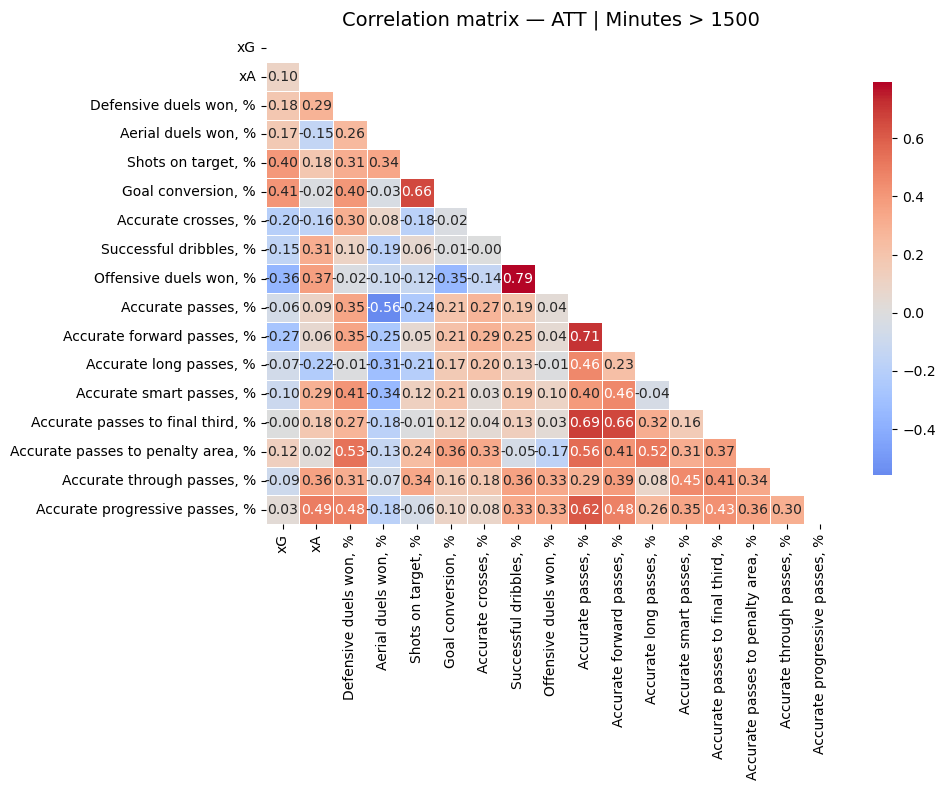

In [113]:
plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation matrix — ATT | Minutes > 1500", fontsize=14)
plt.tight_layout()
plt.show()

Key Correlation Insights

Highly correlated pairs:
* **Successful dribbles % ↔ Offensive duels won %:** Offensive duels won %: Both metrics are essentially capturing the same skill: winning the offensive 1v1. For later analyses, you don’t need both.
* **Goal conversion % ↔ Shots on target %:** Both measure finishing efficiency, not volume. They are redundant as a main axis; it’s better to choose just one.
* **Accurate passes % ↔ Accurate forward passes %:** pass quality and reliability in progression.
* **Accurate passes % ↔ Accurate passes to final third %:** pass quality and reliability in progression.
* **Accurate forward passes % ↔ Accurate passes to final third %:** pass quality and reliability in progression.
* **Accurate passes % ↔ Accurate progressive passes %:** pass quality and reliability in progression.

Moderate correlations:
* **Accurate passes to penalty area % ↔ Accurate smart passes % (~0.55)**
* **Accurate passes to penalty area % ↔ Accurate progressive passes % (~0.55–0.57)**

## 4.4. Performance vs Market Value Relationship

The objective of this section is to explore the relationship between on-field performance and market valuation, and to identify potential market inefficiencies.

For clarity and stability, this analysis focuses only on attacking players with more than 1500 minutes played.<br>
Players with lower exposure are analyzed later during the modeling stage.

### Feature Selection

In [117]:
# Focus on ATT players with >1500 minutes
df_analysis = df_1500_ATT.copy()

The following performance metrics are retained based on the previous correlation and feature-quality analysis.<br>
They capture complementary offensive dimensions without excessive redundancy.

In [119]:
performance_cols = ['xG per 90','xA per 90', 
       'Defensive duels won, %', 'Aerial duels won, %',
       'Shots on target, %', 'Accurate crosses, %', 
       'Offensive duels won, %', 
       'Accurate smart passes, %', 'Accurate passes to final third, %',
      'Accurate through passes, %',
       'Accurate progressive passes, %']

### Performance Score Construction

We compute a simple performance score as the mean of standardized (z-score) metrics

In [122]:
cols_needed = ["Player", "Team", "Market Value (EUR)"] + performance_cols
df_perf = df_analysis[cols_needed].dropna(subset=performance_cols).copy()

Z = (
    df_perf[performance_cols] - df_perf[performance_cols].mean()
) / df_perf[performance_cols].std(ddof=0)

df_perf["performance_score"] = Z.mean(axis=1)



In [123]:
# To improve interpretability, market value is log-transformed
df_perf["log_market_value"] = np.log1p(df_perf["Market Value (EUR)"])

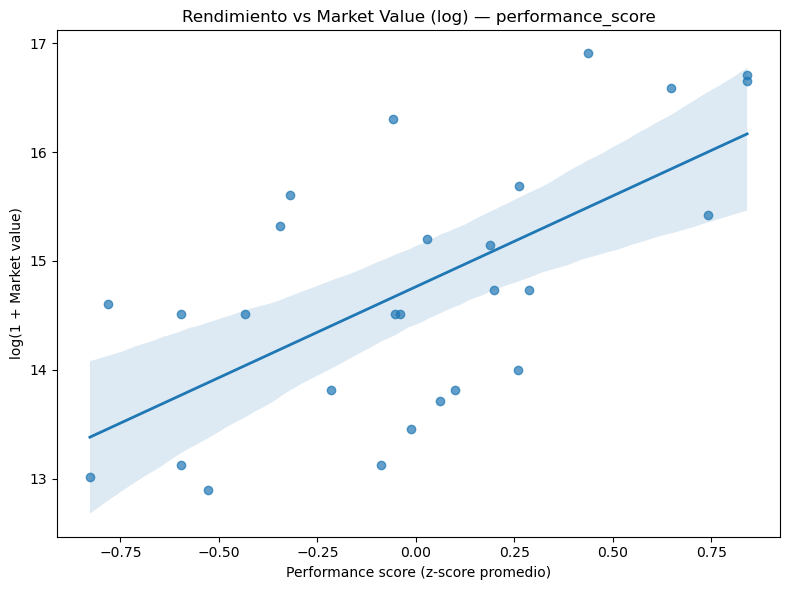

In [124]:
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_perf,
    x="performance_score",
    y="log_market_value",
    scatter_kws={"alpha": 0.7},
    line_kws={"linewidth": 2}
)
plt.title("Rendimiento vs Market Value (log) — performance_score")
plt.xlabel("Performance score (z-score promedio)")
plt.ylabel("log(1 + Market value)")
plt.tight_layout()
plt.show()


This visualization shows a clear positive relationship: players with higher performance tend to have higher market values, while deviations from this trend hint at potential undervalued profiles.

## 4.5. Detection of “good” outliers

The goal is to identify players who combine strong performance metrics with relatively low market value.

Two complementary methods are used.

### 4.5.1. Method A — Percentile-Based Approach

This method defines:
* high performance as the top 40%,
* low price as the bottom 40%.

For interpretability, Offensive duels won % is used as a representative performance metric.

In [129]:
perf_top = 0.60
value_bottom = 0.40

perf_cut = df_perf["performance_score"].quantile(perf_top)
value_cut = df_perf["Market Value (EUR)"].quantile(value_bottom)

good_outliers_A = df_perf[
    (df_perf["performance_score"] >= perf_cut) &
    (df_perf["Market Value (EUR)"] <= value_cut)
].sort_values(
    ["performance_score", "Market Value (EUR)"],
    ascending=[False, True]
)

good_outliers_A[
    ["Player", "Team", "Market Value (EUR)", "performance_score"]
].head(20)



,Player,Team,Market Value (EUR),performance_score
1695,A. Koita,Sint-Truiden,1200000,0.258863
697,F. Reese,Holstein Kiel,1000000,0.100005


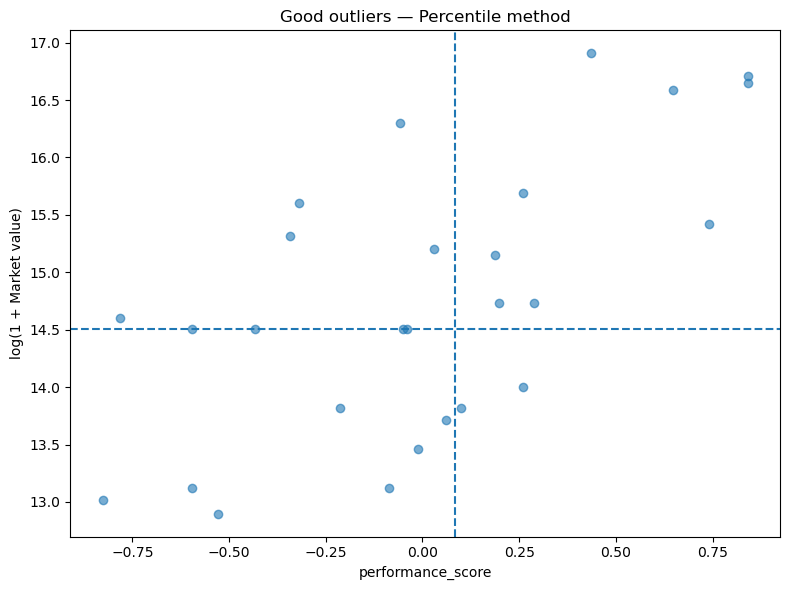

In [130]:
plt.figure(figsize=(8, 6))
plt.scatter(
    df_perf["performance_score"],
    df_perf["log_market_value"],
    alpha=0.6
)

plt.axvline(perf_cut, linestyle="--")
plt.axhline(np.log1p(value_cut), linestyle="--")

plt.title("Good outliers — Percentile method")
plt.xlabel("performance_score")
plt.ylabel("log(1 + Market value)")
plt.tight_layout()
plt.show()



Players in the lower-right quadrant represent attractive scouting targets

### 4.5.2. Method B — Residual-Based Approach (“Undervalued”)

This method models the expected market value given performance and identifies players priced below that expectation.

In [134]:
x = df_perf["performance_score"].values
y = df_perf["log_market_value"].values

slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

df_perf["value_residual"] = y - y_pred  # negative = cheaper than expected


We define “undervalued” players as those in the bottom 10% of residuals, while still showing high performance.

In [136]:
res_cut = df_perf["value_residual"].quantile(0.10)

good_outliers_B = df_perf[
    (df_perf["performance_score"] >= perf_cut) &
    (df_perf["value_residual"] <= res_cut)
].sort_values(
    ["value_residual", "performance_score"],
    ascending=[True, False]
)

good_outliers_B[
    ["Player", "Team", "Market Value (EUR)",
     "performance_score", "value_residual"]
].head(20)



,Player,Team,Market Value (EUR),performance_score,value_residual
1695,A. Koita,Sint-Truiden,1200000,0.258863,-1.197364


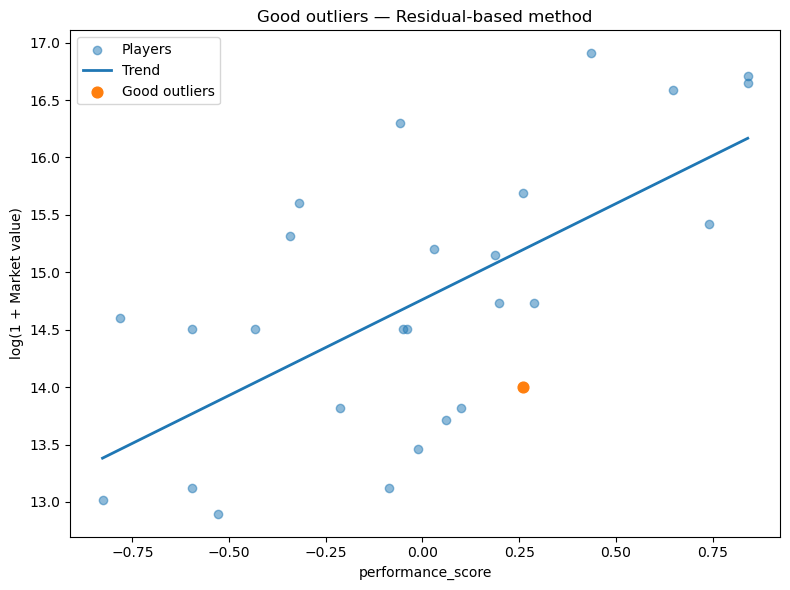

In [137]:
plt.figure(figsize=(8, 6))
plt.scatter(
    df_perf["performance_score"],
    df_perf["log_market_value"],
    alpha=0.5,
    label="Players"
)

x_line = np.linspace(
    df_perf["performance_score"].min(),
    df_perf["performance_score"].max(),
    200
)
y_line = slope * x_line + intercept

plt.plot(x_line, y_line, linewidth=2, label="Trend")
plt.scatter(
    good_outliers_B["performance_score"],
    good_outliers_B["log_market_value"],
    s=60,
    label="Good outliers"
)

plt.title("Good outliers — Residual-based method")
plt.xlabel("performance_score")
plt.ylabel("log(1 + Market value)")
plt.legend()
plt.tight_layout()
plt.show()



---
# 5. Modeling and Insights

This section formalizes the exploratory findings into two complementary modeling approaches:
1. **Scoring Model (recommended):** a transparent, interpretable pipeline to rank Sub-23 attackers by combining performance and market value.
2. **Unsupervised Model (clustering):** a player profiling approach to compare attackers against statistically similar peers and identify cheaper alternatives.


## 5.1. Scoring Model (Value-Based Ranking)

The scoring model is designed to produce a reproducible and interpretable ranking by combining:
* a performance score built from standardized metrics,
* a value score based on market-value inefficiency (residuals),
* and a minutes-based weight to reduce overconfidence in smaller samples.

### 5.1.1. ATT Players with >1500 Minutes
This first scoring pass focuses on high-exposure attackers (>1500 minutes), where performance metrics are more stable.

In [141]:
# 1) Feature selection (based on EDA and correlation diagnostics)
performance_cols = [
    'xG per 90', 'xA per 90',
    'Defensive duels won, %', 'Aerial duels won, %',
    'Shots on target, %', 'Accurate crosses, %',
    'Offensive duels won, %',
    'Accurate smart passes, %',
    'Accurate passes to final third, %',
    'Accurate through passes, %',
    'Accurate progressive passes, %'
]

df_model = df_1500_ATT[
    ["Player", "Team", "Age", "Minutes played", "Market Value (EUR)"] + performance_cols
].dropna().copy()


In [142]:
# 2) Market value transformation (log-scale improves interpretability)
df_model["log_market_value"] = np.log1p(df_model["Market Value (EUR)"])


In [143]:
# 3) Standardization (z-score): ensures all metrics contribute comparably
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[performance_cols])

X_scaled = pd.DataFrame(
    X_scaled,
    columns=performance_cols,
    index=df_model.index
)


In [144]:
# 4) Performance score (baseline): mean standardized performance across selected metrics
df_model["performance_score"] = X_scaled.mean(axis=1)


In [145]:
# 5) Value inefficiency (residuals): identifies players cheaper than expected given performance
x = df_model["performance_score"].values
y = df_model["log_market_value"].values

slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

df_model["value_residual"] = y - y_pred              # negative = undervalued
df_model["value_score"] = -df_model["value_residual"]  # higher = better value



In [146]:
# 6) Minutes-based weighting: reduces overconfidence in lower-exposure players (within the bucket)
df_model["minutes_weight"] = df_model["Minutes played"] / df_model["Minutes played"].max()



In [147]:
# 7) Final score: combines impact (performance) and value (undervaluation)
alpha = 0.7  # weight on performance

df_model["final_score"] = (
    alpha * df_model["performance_score"] +
    (1 - alpha) * df_model["value_score"]
) * df_model["minutes_weight"]



In [148]:
# 8) Ranking output: top scouting targets for ATT (Minutes > 1500)
ranking_ATT_1500 = (
    df_model
    .sort_values("final_score", ascending=False)
    .reset_index(drop=True)
)

ranking_ATT_1500[
    ["Player", "Team", "Age", "Market Value (EUR)",
     "performance_score", "value_score", "final_score"] + performance_cols
].head(15)


,Player,Team,Age,Market Value (EUR),performance_score,value_score,final_score,xG per 90,xA per 90,"Defensive duels won, %","Aerial duels won, %","Shots on target, %","Accurate crosses, %","Offensive duels won, %","Accurate smart passes, %","Accurate passes to final third, %","Accurate through passes, %","Accurate progressive passes, %"
0,M. Balikwisha,Antwerp,20,5000000,0.741850,0.576567,0.470206,0.24,0.07,63.32,23.08,59.26,35.71,35.12,57.14,83.61,60.00,82.41
1,O. Édouard,Celtic,23,17000000,0.840447,-0.482607,0.322118,0.81,0.15,65.38,39.76,51.49,28.57,31.53,39.13,80.56,38.10,88.64
2,A. Koita,Sint-Truiden,22,1200000,0.258863,1.197364,0.307923,0.18,0.10,51.09,28.57,36.07,38.89,44.39,41.67,76.00,52.38,78.26
3,C. Führich,Stuttgart,23,2500000,0.287450,0.511120,0.264657,0.26,0.23,58.33,12.50,41.82,20.45,35.79,55.56,79.49,35.71,84.13
4,F. Reese,Holstein Kiel,23,1000000,0.100005,1.114483,0.253312,0.18,0.13,61.90,50.00,24.62,39.02,35.59,30.00,67.24,28.57,82.14
5,P. Guèye,Kortrijk,21,900000,0.060698,1.154221,0.220337,0.36,0.10,56.52,39.23,50.00,21.43,29.94,62.50,71.43,33.33,58.33
6,K. Diatta,Monaco,22,18000000,0.841000,-0.538843,0.202129,0.40,0.23,66.15,58.97,51.92,32.05,43.97,38.71,60.00,36.84,83.84
7,E. Amenyido,St. Pauli,23,500000,-0.087737,1.494205,0.196047,0.08,0.08,51.43,40.43,38.89,35.29,38.08,30.77,76.74,38.46,69.49
8,B. Goller,Darmstadt 98,22,700000,-0.012364,1.283564,0.192236,0.28,0.12,54.31,34.33,55.00,22.73,40.59,57.14,47.06,33.33,69.81
9,C. De Ketelaere,Club Brugge,20,16000000,0.646715,-0.745406,0.184051,0.19,0.23,56.57,45.16,51.11,38.69,37.34,51.02,65.14,41.30,86.41


### 5.1.2. ATT Players with 300-1500 Minutes

Same methodology as section 5.1.1.

In [150]:
# 1) Feature selection (based on EDA and correlation diagnostics)
performance_cols = [
    'xG per 90', 'xA per 90',
    'Defensive duels won, %', 'Aerial duels won, %',
    'Shots on target, %', 'Accurate crosses, %',
    'Offensive duels won, %',
    'Accurate smart passes, %',
    'Accurate passes to final third, %',
    'Accurate through passes, %',
    'Accurate progressive passes, %'
]

df_model = df_300_1500_ATT[
    ["Player", "Team", "Age", "Minutes played", "Market Value (EUR)"] + performance_cols
].dropna().copy()

In [151]:
# 2) Market value transformation (log-scale improves interpretability)
df_model["log_market_value"] = np.log1p(df_model["Market Value (EUR)"])


In [152]:
# 3) Standardization (z-score): ensures all metrics contribute comparably
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[performance_cols])

X_scaled = pd.DataFrame(
    X_scaled,
    columns=performance_cols,
    index=df_model.index
)


In [153]:
# 4) Performance score (baseline): mean standardized performance across selected metrics
df_model["performance_score"] = X_scaled.mean(axis=1)


In [154]:
# 5) Value inefficiency (residuals): identifies players cheaper than expected given performance
x = df_model["performance_score"].values
y = df_model["log_market_value"].values

slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

df_model["value_residual"] = y - y_pred              # negative = undervalued
df_model["value_score"] = -df_model["value_residual"]  # higher = better value



In [155]:
# 6) Minutes-based weighting: reduces overconfidence in lower-exposure players (within the bucket)
df_model["minutes_weight"] = df_model["Minutes played"] / df_model["Minutes played"].max()



In [156]:
# 7) Final score: combines impact (performance) and value (undervaluation)
alpha = 0.7  # weight on performance

df_model["final_score"] = (
    alpha * df_model["performance_score"] +
    (1 - alpha) * df_model["value_score"]
) * df_model["minutes_weight"]



In [157]:
# 8) Ranking output: top scouting targets for ATT (Minutes > 1500)
ranking_ATT_1500 = (
    df_model
    .sort_values("final_score", ascending=False)
    .reset_index(drop=True)
)

ranking_ATT_1500[
    ["Player", "Team", "Age", "Market Value (EUR)",
     "performance_score", "value_score", "final_score"] + performance_cols
].head(15)


,Player,Team,Age,Market Value (EUR),performance_score,value_score,final_score,xG per 90,xA per 90,"Defensive duels won, %","Aerial duels won, %","Shots on target, %","Accurate crosses, %","Offensive duels won, %","Accurate smart passes, %","Accurate passes to final third, %","Accurate through passes, %","Accurate progressive passes, %"
0,B. Jatta,Hamburger SV,23,1600000,1.020383,0.380113,0.828302,0.16,0.27,69.03,55.13,58.82,29.69,44.55,58.33,62.86,36.36,65.56
1,C. Lang,Wigan Athletic,22,100000,0.061352,2.139308,0.530168,0.22,0.08,46.99,34.15,42.11,20.00,32.60,25.00,78.57,50.00,52.38
2,A. Albanese,Waasland-Beveren,21,500000,0.299555,0.781581,0.416702,0.14,0.12,47.56,31.25,42.11,25.00,48.25,37.50,69.77,36.36,69.70
3,C. Smith,Hamilton Academical,21,250000,0.200212,1.369753,0.381117,0.14,0.02,71.43,21.74,40.00,18.18,28.57,50.00,75.00,60.00,66.67
4,I. Nuhu,Eupen,19,350000,0.814196,1.682064,0.302822,0.34,0.14,56.52,40.00,33.33,33.33,48.33,66.67,57.14,66.67,84.62
5,D. Kother,Karlsruher SC,21,600000,0.310220,0.610530,0.274550,0.24,0.06,48.08,46.88,47.37,19.23,38.71,33.33,60.00,28.57,85.71
6,J. Leweling,Greuther Fürth,20,1500000,0.666774,0.071002,0.269458,0.30,0.17,51.16,31.25,38.10,26.92,40.83,50.00,83.33,50.00,82.35
7,T. Chong,Birmingham City,21,4000000,1.055900,-0.498647,0.191567,0.15,0.35,72.97,16.67,62.50,35.71,39.77,33.33,84.62,33.33,84.62
8,I. Faraj,Mouscron,22,500000,0.055937,0.524155,0.181012,0.11,0.11,61.70,34.78,33.33,26.83,50.00,0.00,58.33,0.00,62.86
9,O. Shaw,Ross County,22,325000,-0.104376,0.785539,0.157455,0.22,0.06,45.83,29.93,34.38,27.27,26.36,25.00,75.00,25.00,66.67


## 5.2. Unsupervised Model — Clustering

While the scoring model provides a global ranking, clustering is used to identify player profiles and enable fair comparisons between similar attackers.

This approach helps answer questions such as:
- What type of attacker is this player?
- Who are similar players with better value?

### 5.2.1. ATT Players with >1500 Minutes

In [160]:
# Feature Selection
performance_cols = [
    'xG per 90', 'xA per 90',
    'Defensive duels won, %', 'Aerial duels won, %',
    'Shots on target, %', 'Accurate crosses, %',
    'Offensive duels won, %',
    'Accurate smart passes, %',
    'Accurate passes to final third, %',
    'Accurate through passes, %',
    'Accurate progressive passes, %'
]

df_cluster = df_1500_ATT[
    ["Player", "Team", "Age", "Minutes played", "Market Value (EUR)"] + performance_cols
].dropna().copy()


In [161]:
# Preprocessing: Standardization

scaler = StandardScaler()
X = scaler.fit_transform(df_cluster[performance_cols])

In [162]:
# Choosing the Number of Clusters (k)
# A silhouette-based approach is used to select a defensible number of clusters.

k_candidates = range(2, 8)
sil_scores = {}

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil_scores[k] = silhouette_score(X, labels)

best_k = max(sil_scores, key=sil_scores.get)
best_k, sil_scores

(2,
 {2: 0.16054178368180594,
  3: 0.12496493885376231,
  4: 0.11081691265805774,
  5: 0.11447257424857697,
  6: 0.09615368328708819,
  7: 0.11884062995258003})

In [163]:
# Final K-Means Model
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_cluster["cluster"] = kmeans.fit_predict(X)

In [164]:
# Cluster Interpretation (Average Profiles)
cluster_profiles = (
    df_cluster
    .groupby("cluster")[performance_cols]
    .mean()
    .round(2)
)

cluster_sizes = df_cluster["cluster"].value_counts().sort_index()

cluster_sizes, cluster_profiles

(cluster
 0    17
 1    10
 Name: count, dtype: int64,
          xG per 90  xA per 90  Defensive duels won, %  Aerial duels won, %  \
 cluster                                                                      
 0             0.30       0.09                   52.89                33.50   
 1             0.34       0.19                   57.74                29.52   
 
          Shots on target, %  Accurate crosses, %  Offensive duels won, %  \
 cluster                                                                    
 0                     39.85                28.72                   34.20   
 1                     43.23                29.75                   41.27   
 
          Accurate smart passes, %  Accurate passes to final third, %  \
 cluster                                                                
 0                           37.13                              62.61   
 1                           47.43                              70.90   
 
          Accurate thro

These averages allow each cluster to be interpreted as a distinct offensive profile, rather than a quality ranking.

In [166]:
# Ranking Within Each Cluster
# To ensure fair comparisons, players are ranked only within their own cluster, using the final score obtained in the scoring model.

df_cluster["log_market_value"] = np.log1p(df_cluster["Market Value (EUR)"])

# performance_score simple
X_scaled_df = pd.DataFrame(X, columns=performance_cols, index=df_cluster.index)
df_cluster["performance_score"] = X_scaled_df.mean(axis=1)

# residual per cluster
df_cluster["value_residual"] = np.nan

for c in df_cluster["cluster"].unique():
    idx = df_cluster["cluster"] == c
    x = df_cluster.loc[idx, "performance_score"].values
    y = df_cluster.loc[idx, "log_market_value"].values
    
    # to avoid small clusters
    if len(x) < 10:
        continue
    
    slope, intercept = np.polyfit(x, y, 1)
    df_cluster.loc[idx, "value_residual"] = y - (slope * x + intercept)

df_cluster["value_score"] = -df_cluster["value_residual"]

alpha = 0.7
df_cluster["final_score"] = alpha * df_cluster["performance_score"] + (1 - alpha) * df_cluster["value_score"]

In [167]:
# Ranking Within Each Cluster
# To ensure fair comparisons, players are ranked only within their own cluster, using the final score obtained in the scoring model.

top_per_cluster = (
    df_cluster
    .sort_values("final_score", ascending=False)
    .groupby("cluster")
    .head(10)[["Player", "Team", "Age", "Market Value (EUR)", "cluster", "performance_score", "value_score", "final_score"]]
    .reset_index(drop=True)
)

top_per_cluster


,Player,Team,Age,Market Value (EUR),cluster,performance_score,value_score,final_score
0,M. Balikwisha,Antwerp,20,5000000,1,0.741850,0.946259,0.803173
1,O. Édouard,Celtic,23,17000000,1,0.840447,-0.018533,0.582753
2,K. Diatta,Monaco,22,18000000,1,0.841000,-0.074240,0.566428
3,A. Koita,Sint-Truiden,22,1200000,1,0.258863,1.104716,0.512619
4,C. Führich,Stuttgart,23,2500000,1,0.287450,0.445837,0.334966
5,C. De Ketelaere,Club Brugge,20,16000000,1,0.646715,-0.466781,0.312666
6,E. Amenyido,St. Pauli,23,500000,0,-0.087737,1.244395,0.311903
7,B. Goller,Darmstadt 98,22,700000,0,-0.012364,0.959740,0.279267
8,F. Reese,Holstein Kiel,23,1000000,0,0.100005,0.680315,0.274098
9,P. Guèye,Kortrijk,21,900000,0,0.060698,0.758653,0.270084


In [168]:
# Cluster Visualization (PCA Projection)
# To visualize the clusters, the standardized feature space is projected into two dimensions using PCA.

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df_cluster["pca_1"] = X_pca[:, 0]
df_cluster["pca_2"] = X_pca[:, 1]

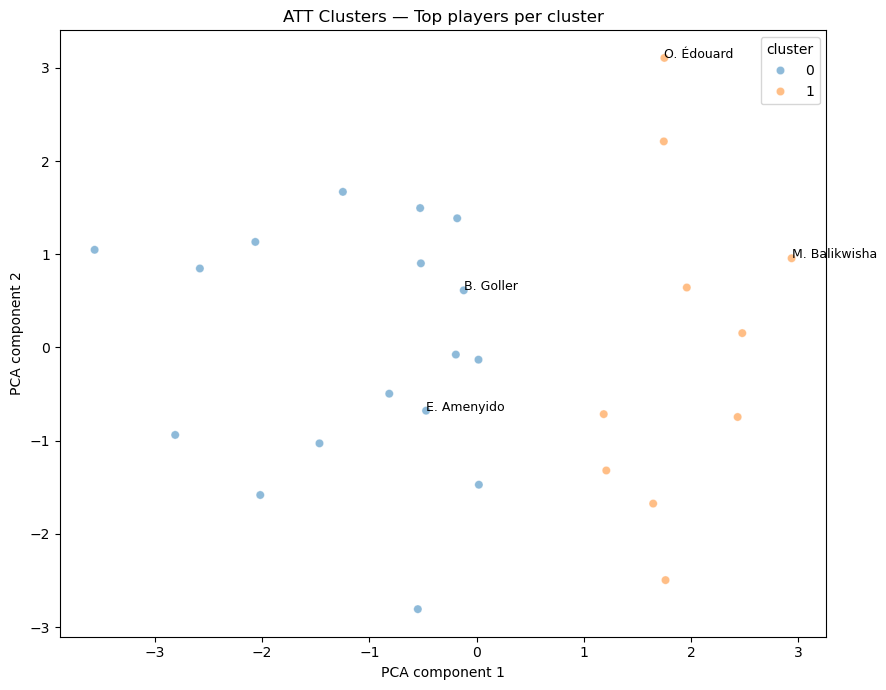

In [169]:
top_players = (
    df_cluster
    .sort_values("final_score", ascending=False)
    .groupby("cluster")
    .head(2)
)

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=df_cluster,
    x="pca_1",
    y="pca_2",
    hue="cluster",
    palette="tab10",
    alpha=0.5
)

for _, r in top_players.iterrows():
    plt.text(r["pca_1"], r["pca_2"], r["Player"], fontsize=9)

plt.title("ATT Clusters — Top players per cluster")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.tight_layout()
plt.show()


## Cluster Interpretation — Insights

The PCA visualization of the clusters shows a clear separation between different offensive profiles, with groups capturing more vertical attackers, finishers, balanced profiles, and efficient players. This confirms that the clustering groups players by style of play rather than overall level.

Reading by zones:
1) Cluster 1:<br>
   Players such as O. Edouard y M. Balikwisha tend to correspond to vertical profiles with strong ball carrying, progression, and dribbling. These are wingers rather than classic “number 9” forwards
5) Cluster 0:<br>
   Players such as L. Appéré, K. Magennis, C. Lang tend to be more hybrid profiles, without extreme specialization; functional, well-rounded attackers.

### 5.2.2. ATT Players with 300-1500 Minutes

In [174]:
# Feature Selection
performance_cols = [
    'xG per 90', 'xA per 90',
    'Defensive duels won, %', 'Aerial duels won, %',
    'Shots on target, %', 'Accurate crosses, %',
    'Offensive duels won, %',
    'Accurate smart passes, %',
    'Accurate passes to final third, %',
    'Accurate through passes, %',
    'Accurate progressive passes, %'
]

df_cluster = df_300_1500_ATT[
    ["Player", "Team", "Age", "Minutes played", "Market Value (EUR)"] + performance_cols
].dropna().copy()


In [175]:
# Preprocessing: Standardization

scaler = StandardScaler()
X = scaler.fit_transform(df_cluster[performance_cols])

In [176]:
# Choosing the Number of Clusters (k)
# A silhouette-based approach is used to select a defensible number of clusters.

k_candidates = range(2, 8)
sil_scores = {}

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil_scores[k] = silhouette_score(X, labels)

best_k = max(sil_scores, key=sil_scores.get)
best_k, sil_scores

(2,
 {2: 0.14830525496102742,
  3: 0.13288773123492104,
  4: 0.11388022324388491,
  5: 0.11669081208979538,
  6: 0.09020482745407281,
  7: 0.10356230858695244})

In [177]:
# Final K-Means Model
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_cluster["cluster"] = kmeans.fit_predict(X)

In [178]:
# Cluster Interpretation (Average Profiles)
cluster_profiles = (
    df_cluster
    .groupby("cluster")[performance_cols]
    .mean()
    .round(2)
)

cluster_sizes = df_cluster["cluster"].value_counts().sort_index()

cluster_sizes, cluster_profiles

(cluster
 0    22
 1    29
 Name: count, dtype: int64,
          xG per 90  xA per 90  Defensive duels won, %  Aerial duels won, %  \
 cluster                                                                      
 0             0.30       0.04                   56.39                24.10   
 1             0.21       0.11                   51.94                34.92   
 
          Shots on target, %  Accurate crosses, %  Offensive duels won, %  \
 cluster                                                                    
 0                     38.56                 7.64                   28.86   
 1                     35.02                29.51                   39.18   
 
          Accurate smart passes, %  Accurate passes to final third, %  \
 cluster                                                                
 0                           28.83                              55.41   
 1                           32.49                              61.08   
 
          Accurate thro

In [179]:
# Ranking Within Each Cluster
# To ensure fair comparisons, players are ranked only within their own cluster, using the final score obtained in the scoring model.

df_cluster["log_market_value"] = np.log1p(df_cluster["Market Value (EUR)"])

# performance_score simple
X_scaled_df = pd.DataFrame(X, columns=performance_cols, index=df_cluster.index)
df_cluster["performance_score"] = X_scaled_df.mean(axis=1)

# residual per cluster
df_cluster["value_residual"] = np.nan

for c in df_cluster["cluster"].unique():
    idx = df_cluster["cluster"] == c
    x = df_cluster.loc[idx, "performance_score"].values
    y = df_cluster.loc[idx, "log_market_value"].values
    
    # to avoid small clusters
    if len(x) < 10:
        continue
    
    slope, intercept = np.polyfit(x, y, 1)
    df_cluster.loc[idx, "value_residual"] = y - (slope * x + intercept)

df_cluster["value_score"] = -df_cluster["value_residual"]

alpha = 0.7
df_cluster["final_score"] = alpha * df_cluster["performance_score"] + (1 - alpha) * df_cluster["value_score"]

In [180]:
# Ranking Within Each Cluster
# To ensure fair comparisons, players are ranked only within their own cluster, using the final score obtained in the scoring model.

top_per_cluster = (
    df_cluster
    .sort_values("final_score", ascending=False)
    .groupby("cluster")
    .head(10)[["Player", "Team", "Age", "Market Value (EUR)", "cluster", "performance_score", "value_score", "final_score"]]
    .reset_index(drop=True)
)

top_per_cluster


,Player,Team,Age,Market Value (EUR),cluster,performance_score,value_score,final_score
0,I. Nuhu,Eupen,19,350000,1,0.814196,1.798578,1.109511
1,B. Jatta,Hamburger SV,23,1600000,1,1.020383,0.557008,0.881370
2,C. Lang,Wigan Athletic,22,100000,1,0.061352,2.035358,0.653554
3,T. Chong,Birmingham City,21,4000000,1,1.055900,-0.311351,0.645725
4,C. Smith,Hamilton Academical,21,250000,0,0.200212,1.344897,0.543617
5,J. Leweling,Greuther Fürth,20,1500000,1,0.666774,0.144345,0.510045
6,A. Albanese,Waasland-Beveren,21,500000,1,0.299555,0.747387,0.433905
7,K. Ofori,Fortuna Düsseldorf,20,500000,1,0.262840,0.697840,0.393340
8,D. Kother,Karlsruher SC,21,600000,1,0.310220,0.579459,0.390992
9,Y. Otto,Eintracht Braunschweig,22,250000,1,0.013619,1.054657,0.325931


In [181]:
# Cluster Visualization (PCA Projection)
# To visualize the clusters, the standardized feature space is projected into two dimensions using PCA.

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df_cluster["pca_1"] = X_pca[:, 0]
df_cluster["pca_2"] = X_pca[:, 1]

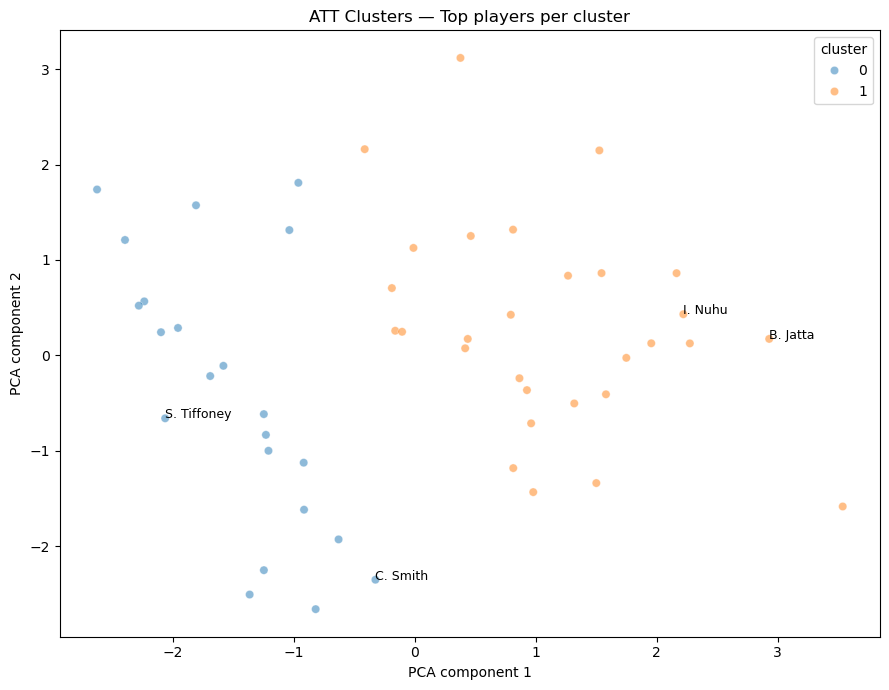

In [182]:
top_players = (
    df_cluster
    .sort_values("final_score", ascending=False)
    .groupby("cluster")
    .head(2)
)

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=df_cluster,
    x="pca_1",
    y="pca_2",
    hue="cluster",
    palette="tab10",
    alpha=0.5
)

for _, r in top_players.iterrows():
    plt.text(r["pca_1"], r["pca_2"], r["Player"], fontsize=9)

plt.title("ATT Clusters — Top players per cluster")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.tight_layout()
plt.show()


## Cluster Interpretation — Insights

The PCA visualization for attackers with 300–1500 minutes played shows a clear separation into two distinct clusters, indicating that even with limited exposure, players already display identifiable offensive styles. 

Compared to the >1500-minute group, this distribution is more dispersed, which is expected given the higher variance associated with smaller sample sizes. Importantly, the clustering suggests that the model is capturing meaningful behavioral patterns rather than pure noise.

Cluster 0:
* The cluster on the left side of the plot tends to group players with lower verticality and more limited offensive impact.
* These profiles often correspond to attackers with irregular production, secondary roles, or clearer technical or physical constraints.
* From a scouting perspective, this group is generally less attractive unless the player’s market value is extremely low or there is strong contextual justification (e.g., team role, age, or tactical fit).

Cluster 1:
* The right-side cluster groups more vertical and dynamic profiles, characterized by stronger ball progression, attacking initiative, and clearer offensive contribution despite fewer minutes played.
* This cluster is particularly relevant for scouting, as it contains players who show early signals of impact and upside. When these profiles also rank well in the scoring model, they represent strong candidates for early identification, potential breakout seasons, and market inefficiencies.